In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# importing the models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


# addition predifined 'functions' for splitting the data and evaluating the model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)


from xgboost import XGBClassifier


# Support functions

In [3]:
class match_support_functions():
        
    def categorical_to_numerical_convert(self,df,cat_columns):

        for column in cat_columns:
            one_hot = pd.get_dummies(df[column])
            # Drop column as it is now encoded
            df = df.drop(column,axis = 1)
            # Join the encoded df
            df = df.join(one_hot)

        return df

    def IQR_outlier_treatment(self,df, datacolumn, V1 , V3):
        
        print(datacolumn,V1,V3)

        Q1,Q3 = np.percentile(df[datacolumn] , [V1,V3])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        #print(f'{datacolumn} minimum range:',lower_range)
        #print(f'{datacolumn} maximum range:',upper_range) 
        df = df[(df[datacolumn] > lower_range) & (df[datacolumn] < upper_range)]
        
        return df
        
    def get_top_correlation(self,df):
        cor = df.corr().abs()
        cor2 = cor.unstack()
        cor3 = cor2.sort_values(kind="quicksort", ascending = False)

        return pd.DataFrame(cor3)

    def evaluate_prediction(self,y_prediction,y_val):
        
        mse = mean_squared_error(y_val, y_prediction)
        rmse = mean_squared_error(y_val, y_prediction, squared=False)
        rx = r2_score(y_val, y_prediction)
        print('model mean squared error:',mse)
        print('model root mean squared error:',rmse)
        print('model R2:',rx)


    def try_models(self,model_type,X_train,y_train,X_val,y_val):
        model = model_type
        model.fit(X_train, y_train)
        print('='*20)
        print(f'{model_type}')
        print(f'accuracy of train set: {model.score(X_train, y_train)}')
        print(f'accuracy of val set: {model.score(X_val, y_val)}')
        y_prediction = model.predict(X_val)
        self.evaluate_prediction(y_prediction,y_val)
        
        return model
    

# Script starts here

In [4]:
df = pd.read_csv("match_data.csv")
df.head()

# Feature Engineering

In [6]:
df["home_win_expected"] = np.where((df["odds_home_team_win"] < df["odds_draw"]) & 
                                   (df["odds_home_team_win"] < df["odds_away_team_win"]),1,0)

df["home_win_accuracy"] = np.where(df["home_win_flag"] == df["home_win_expected"],1,0)

# df["draw_expected"] = np.where((df["odds_draw"] <= df["odds_home_team_win"]) & 
#                                (df["odds_draw"] <= df["odds_away_team_win"]),1,0)

# df["away_win_expected"] = np.where((df["odds_away_team_win"] < df["odds_draw"]) & 
#                                    (df["odds_away_team_win"] < df["odds_home_team_win"]),1,0)

# df["flag_concat"] = df["home_win_flag"].astype(str) + df["draw_flag"].astype(str) + + df["away_win_flag"].astype(str)
# df["expected_concat"] = df["home_win_expected"].astype(str) + df["draw_expected"].astype(str) + + df["away_win_expected"].astype(str)
# df["expectation_accuracy"] = np.where(df["flag_concat"] == df["expected_concat"],1,0)

In [7]:
# div accuracy
acc_df = pd.DataFrame(df.groupby(["div"])["home_win_accuracy"].mean())
acc_df = acc_df.reset_index(level=['div'])
acc_df.columns = ["div","div_home_acc"]

df2 = pd.merge(df, acc_df, on=["div"], how = "left")
df2['home_win_prob'] = np.where( 1/df2['odds_home_team_win'] > 1 ,1 ,1/df2['odds_home_team_win'])
df2['draw_prob'] = np.where( 1/df2['odds_draw'] > 1 ,1 ,1/df2['odds_draw'])

# Added metrics

In [8]:
# good 67.42
df2["home_team_roll4_points_diff"] = df2["home_team_point_roll4_sum"]-df2["home_team_expected_point_roll4_sum"]
df2["away_team_roll4_points_diff"] = df2["away_team_point_roll4_sum"]-df2["away_team_expected_point_roll4_sum"]
# good 67.46
df2["home_team_roll1_points_diff"] = df2["home_team_point_roll1_sum"]-df2["home_team_expected_point_roll1_sum"]
df2["away_team_roll1_points_diff"] = df2["home_team_point_roll1_sum"]-df2["home_team_expected_point_roll1_sum"]

# extra
df2["home_team_all_points_diff"] = df2["home_team_point_mean"]-df2["home_team_expected_point_mean"]
df2["away_team_all_points_diff"] = df2["away_team_point_mean"]-df2["away_team_expected_point_mean"]
df2["home_s_p1"] = np.where(df2["home_team_match_nr"]<19,1,0)
df2["home_s_p2"] = np.where(df2["home_team_match_nr"]>=19,1,0)

df2["away_s_p1"] = np.where(df2["away_team_match_nr"]<19,1,0)
df2["away_s_p2"] = np.where(df2["away_team_match_nr"]>=19,1,0)

# sample prepare

In [9]:
### Train

data = df2.copy()

data_y1= data[data['home_win_flag']==1].reset_index(drop=True)
data_y0= data[data['home_win_flag']==0].reset_index(drop=True)

#selectiong train features(X_train) and train targets(y_train)
# train_feature = ['div_season_home_acc','home_win_prob',
#                  'home_team_match_nr','home_team_goal_roll4_sum','home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'home_team_goal_roll1_sum','home_team_opponents_goal_roll1_sum',
#                  'home_team_point_roll1_sum','home_team_expected_point_roll1_sum',
#                  'away_team_match_nr','away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'away_team_goal_roll1_sum','away_team_opponents_goal_roll1_sum',
#                  'away_team_point_roll1_sum','away_team_expected_point_roll1_sum']


train_feature = ['home_win_prob',
                 'home_team_opponents_goal_roll4_sum',
                 'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
                 'away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
                 'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
                 'home_team_roll4_points_diff','away_team_roll4_points_diff',
                 'home_team_roll1_points_diff','away_team_roll1_points_diff',
                 'home_s_p1','home_s_p2',
                 'away_s_p1','away_s_p2']

train_target = 'home_win_flag'

### Train
data_to_train = pd.concat([data_y1[0:20000],data_y0[0:20000]], ignore_index=True)
X_train = data_to_train[train_feature].values
y_train = data_to_train[train_target].values

### Test
data_to_test = pd.concat([data_y1[20000:28000],data_y0[20000:28000]], ignore_index=True)
X_test = data_to_test[train_feature].values
y_test = data_to_test[train_target].values

In [10]:
support_functions = match_support_functions()

# Models

In [11]:
from sklearn.ensemble import RandomForestClassifier


models = [LinearRegression(),
          GaussianNB(),BernoulliNB(),
          RandomForestRegressor(),
          RandomForestClassifier(),
          XGBClassifier()]

print('start model trials')
for modelx in models:
    support_functions.try_models(modelx,X_train,y_train,X_test,y_test)

start model trials
LinearRegression()
accuracy of train set: 0.09763843681104678
accuracy of val set: 0.0972204341624181
model mean squared error: 0.22569489145939547
model root mean squared error: 0.4750735642607316
model R2: 0.0972204341624181
GaussianNB()
accuracy of train set: 0.61325
accuracy of val set: 0.61825
model mean squared error: 0.38175
model root mean squared error: 0.6178592072632728
model R2: -0.5269999999999999
BernoulliNB()
accuracy of train set: 0.558775
accuracy of val set: 0.5684375
model mean squared error: 0.4315625
model root mean squared error: 0.6569341671735457
model R2: -0.7262500000000001
RandomForestRegressor()
accuracy of train set: 0.867361384248186
accuracy of val set: 0.019405415636684187
model mean squared error: 0.24514864609082895
model root mean squared error: 0.495124879288881
model R2: 0.019405415636684187
RandomForestClassifier()
accuracy of train set: 0.9997
accuracy of val set: 0.5963125
model mean squared error: 0.4036875
model root mean squ

### choose model

In [12]:
# gaussian purely on odds

In [13]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)

GaussianNB()
accuracy of train set: 0.61325
accuracy of val set: 0.61825
model mean squared error: 0.38175
model root mean squared error: 0.6178592072632728
model R2: -0.5269999999999999


In [14]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)
y_prediction = model.predict_proba(X_test)[:,1]
data_to_test["pred"] = y_prediction
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred'] )
print("auc:",auc)

GaussianNB()
accuracy of train set: 0.61325
accuracy of val set: 0.61825
model mean squared error: 0.38175
model root mean squared error: 0.6178592072632728
model R2: -0.5269999999999999
auc: 0.670354375


# Kill Bill

In [15]:
all_cols = df2.columns.tolist()
all_cols.remove('match_id')
all_cols.remove('season')
all_cols.remove('div')
all_cols.remove('home_win_flag')
all_cols.remove('draw_flag')
all_cols.remove('away_win_flag')
all_cols.remove('home_win_expected')
all_cols.remove('home_win_accuracy')

In [66]:
# all_cols = ['odds_home_team_win',
#  'odds_draw',
#  'home_team_match_nr',
#  'home_team_opponents_goal_roll1_sum',
#  'home_team_opponents_goal_roll3_sum',
#  'home_team_opponents_goal_roll4_sum',
#  'home_team_shot_roll2_sum',
#  'home_team_shot_roll3_sum',
#  'home_team_shot_roll4_sum',
#  'home_team_opponents_shot_on_target_roll1_sum',
#  'home_team_opponents_shot_on_target_roll3_sum',
#  'home_team_opponents_shot_on_target_roll4_sum',
#  'home_team_fault_roll1_sum',
#  'home_team_fault_roll2_sum',
#  'home_team_fault_roll3_sum',
#  'home_team_fault_roll4_sum',
#  'home_team_opponents_corner_roll1_sum',
#  'home_team_opponents_corner_roll2_sum',
#  'home_team_opponents_corner_roll3_sum',
#  'home_team_opponents_corner_roll4_sum',
#  'home_team_yellow_card_roll1_sum',
#  'home_team_yellow_card_roll2_sum',
#  'home_team_yellow_card_roll3_sum',
#  'home_team_yellow_card_roll4_sum',
#  'home_team_opponents_yellow_card_roll1_sum',
#  'home_team_opponents_yellow_card_roll3_sum',
#  'home_team_red_card_roll1_sum',
#  'home_team_red_card_roll2_sum',
#  'home_team_red_card_roll3_sum',
#  'home_team_red_card_roll4_sum',
#  'home_team_point_roll1_sum',
#  'home_team_expected_point_roll3_sum',
#  'home_team_expected_point_roll4_sum',
#  'odds_home_team_win_roll1_mean',
#  'odds_home_team_win_roll2_mean',
#  'odds_home_team_win_roll3_mean',
#  'odds_home_team_win_roll4_mean',
#  'away_team_match_nr',
#  'away_team_goal_roll4_sum',
#  'away_team_opponents_shot_roll1_sum',
#  'away_team_opponents_shot_roll2_sum',
#  'away_team_opponents_shot_roll3_sum',
#  'away_team_opponents_shot_roll4_sum',
#  'away_team_shot_on_target_roll1_sum',
#  'away_team_shot_on_target_roll3_sum',
#  'away_team_shot_on_target_roll4_sum',
#  'away_team_fault_roll1_sum',
#  'away_team_opponents_fault_roll1_sum',
#  'away_team_corner_roll1_sum',
#  'away_team_corner_roll2_sum',
#  'away_team_corner_roll3_sum',
#  'away_team_corner_roll4_sum',
#  'away_team_yelllow_card_roll1_sum',
#  'away_team_opponents_yellow_card_roll1_sum',
#  'away_team_opponents_yellow_card_roll2_sum',
#  'away_team_opponents_yellow_card_roll4_sum',
#  'away_team_opponents_red_card_roll1_sum',
#  'away_team_opponents_red_card_roll2_sum',
#  'away_team_point_roll1_sum',
#  'away_team_expected_point_roll1_sum',
#  'odds_away_team_win_roll1_mean',
#  'odds_away_team_draw_roll1_mean',
#  'odds_away_team_draw_roll2_mean',
#  'odds_away_team_defeat_roll1_mean',
#  'odds_away_team_defeat_roll2_mean',
#  'odds_away_team_defeat_roll3_mean',
#  'odds_away_team_defeat_roll4_mean',
#  'div_home_acc',
#  'home_win_prob',
#  'draw_prob',
#  'home_team_roll4_points_diff',
#  'away_team_roll4_points_diff',
#  'home_team_roll1_points_diff',
#  'away_team_roll1_points_diff',
#  'home_s_p1',
#  'home_s_p2',
#  'away_s_p1',
#  'away_s_p2']

In [67]:
train_feature = all_cols

best_features = {}
auc_abs_max = 0
test_accuracy_abs_max = 0


for i in range(len(train_feature)-1):
    
    auc_max = 0

    for x in data_to_test[train_feature].columns:

        train_feature_x = [n for n in train_feature if n != x]


        X_train = data_to_train[train_feature_x].values
        y_train = data_to_train[train_target].values

        ### Test
        X_test = data_to_test[train_feature_x].values
        y_test = data_to_test[train_target].values

        print("******  ",x,"  ********")
        model = GaussianNB().fit(X_train,y_train)
        accuracy = model.score(X_test, y_test)
        y_prediction = model.predict_proba(X_test)[:,1]
        data_to_test["pred"] = y_prediction
        auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred'] )
        print("auc:",auc)
        
        if auc > auc_max:

            auc_max = auc
            auc_list = []
            auc_list.append(x)
            auc_list.append(auc)
    
        if auc > auc_abs_max:
        
            auc_abs_max = auc
            best_features["best_auc"] = train_feature_x
            
        if accuracy > test_accuracy_abs_max:
        
            test_accuracy_abs_max = accuracy
            best_features["best_acc"] = train_feature_x
    
    train_feature.remove(auc_list[0])

******   odds_home_team_win   ********
auc: 0.6942563046875
******   odds_draw   ********
auc: 0.69602828125
******   home_team_match_nr   ********
auc: 0.697073453125
******   home_team_opponents_goal_roll1_sum   ********
auc: 0.6970848671875
******   home_team_opponents_goal_roll3_sum   ********
auc: 0.6971233437500001
******   home_team_opponents_goal_roll4_sum   ********
auc: 0.6970566640625
******   home_team_shot_roll2_sum   ********
auc: 0.6969058437500001
******   home_team_shot_roll3_sum   ********
auc: 0.6970596953125001
******   home_team_shot_roll4_sum   ********
auc: 0.6970334921875
******   home_team_opponents_shot_on_target_roll1_sum   ********
auc: 0.6970875624999999
******   home_team_opponents_shot_on_target_roll3_sum   ********
auc: 0.6970068671875
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.69678884375
******   home_team_fault_roll1_sum   ********
auc: 0.6970272265625
******   home_team_fault_roll2_sum   ********
auc: 0.69700859375
******

auc: 0.69694103125
******   away_team_opponents_shot_roll1_sum   ********
auc: 0.6971880703125001
******   away_team_opponents_shot_roll2_sum   ********
auc: 0.6972419921875
******   away_team_opponents_shot_roll3_sum   ********
auc: 0.6968948984375
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.6968027578124999
******   away_team_shot_on_target_roll1_sum   ********
auc: 0.6971812109375001
******   away_team_shot_on_target_roll3_sum   ********
auc: 0.69711209375
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.69705921875
******   away_team_fault_roll1_sum   ********
auc: 0.6971686328125
******   away_team_opponents_fault_roll1_sum   ********
auc: 0.6972088359374999
******   away_team_corner_roll1_sum   ********
auc: 0.6969710078125
******   away_team_corner_roll2_sum   ********
auc: 0.6967557578125
******   away_team_corner_roll3_sum   ********
auc: 0.6965038828125001
******   away_team_corner_roll4_sum   ********
auc: 0.6962068828125001
******   away_team_

auc: 0.6974606406249999
******   home_team_opponents_goal_roll1_sum   ********
auc: 0.6974392421875
******   home_team_opponents_goal_roll4_sum   ********
auc: 0.6973509375
******   home_team_shot_roll2_sum   ********
auc: 0.6970029687500001
******   home_team_shot_roll4_sum   ********
auc: 0.6970898984375
******   home_team_opponents_shot_on_target_roll1_sum   ********
auc: 0.69747246875
******   home_team_opponents_shot_on_target_roll3_sum   ********
auc: 0.6973689843750001
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.697143984375
******   home_team_fault_roll1_sum   ********
auc: 0.697427390625
******   home_team_fault_roll2_sum   ********
auc: 0.6973968281249998
******   home_team_fault_roll3_sum   ********
auc: 0.6974122890625
******   home_team_fault_roll4_sum   ********
auc: 0.6974047031249999
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.6972415859375
******   home_team_opponents_corner_roll2_sum   ********
auc: 0.6971924609375
*****

auc: 0.6975825390625
******   away_team_opponents_fault_roll1_sum   ********
auc: 0.6976208750000001
******   away_team_corner_roll1_sum   ********
auc: 0.6973837421875
******   away_team_corner_roll2_sum   ********
auc: 0.6971534531250001
******   away_team_corner_roll3_sum   ********
auc: 0.6968948984375001
******   away_team_corner_roll4_sum   ********
auc: 0.6966006718750001
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.6974749062499999
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6975045703125
******   away_team_opponents_yellow_card_roll2_sum   ********
auc: 0.6975806796875
******   away_team_opponents_yellow_card_roll4_sum   ********
auc: 0.6975921250000001
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.6974859453125
******   away_team_opponents_red_card_roll2_sum   ********
auc: 0.697567828125
******   away_team_point_roll1_sum   ********
auc: 0.6976009218749999
******   away_team_expected_point_roll1_sum   ********
auc: 

auc: 0.697818609375
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.6976275234374999
******   home_team_opponents_corner_roll2_sum   ********
auc: 0.6975879609375
******   home_team_opponents_corner_roll3_sum   ********
auc: 0.6973560468750001
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.6971462187499999
******   home_team_yellow_card_roll1_sum   ********
auc: 0.6978079609375001
******   home_team_yellow_card_roll2_sum   ********
auc: 0.6978447734375001
******   home_team_yellow_card_roll3_sum   ********
auc: 0.69790696875
******   home_team_yellow_card_roll4_sum   ********
auc: 0.697921609375
******   home_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6978084140625
******   home_team_opponents_yellow_card_roll3_sum   ********
auc: 0.697737796875
******   home_team_red_card_roll1_sum   ********
auc: 0.6977966015624999
******   home_team_red_card_roll2_sum   ********
auc: 0.6978442968749998
******   home_team_red_card_roll3_sum   ********
auc:

auc: 0.6976154375000001
******   odds_away_team_win_roll1_mean   ********
auc: 0.6976931562500001
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6975775781250001
******   odds_away_team_draw_roll2_mean   ********
auc: 0.6975699843750001
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.69764365625
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.6976804609374999
******   odds_away_team_defeat_roll4_mean   ********
auc: 0.6978429296875001
******   div_home_acc   ********
auc: 0.6978995546875
******   home_win_prob   ********
auc: 0.69715775
******   draw_prob   ********
auc: 0.6968737968750001
******   away_team_roll4_points_diff   ********
auc: 0.6978061171875001
******   home_team_roll1_points_diff   ********
auc: 0.6978447734375
******   away_team_roll1_points_diff   ********
auc: 0.6978447734375
******   home_s_p1   ********
auc: 0.6979310546874999
******   home_s_p2   ********
auc: 0.6979310546874999
******   away_s_p1   ********
auc: 0.6979293515625

auc: 0.6980492890625001
******   odds_home_team_win_roll3_mean   ********
auc: 0.6978167031250001
******   odds_home_team_win_roll4_mean   ********
auc: 0.6975553828125
******   away_team_match_nr   ********
auc: 0.6982374453125
******   away_team_goal_roll4_sum   ********
auc: 0.6979527812499999
******   away_team_opponents_shot_roll1_sum   ********
auc: 0.6980872031249999
******   away_team_opponents_shot_roll3_sum   ********
auc: 0.6977221874999999
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.6976043515624999
******   away_team_shot_on_target_roll3_sum   ********
auc: 0.6981274765625001
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.698099671875
******   away_team_fault_roll1_sum   ********
auc: 0.698214578125
******   away_team_corner_roll1_sum   ********
auc: 0.6979925703125001
******   away_team_corner_roll2_sum   ********
auc: 0.6977436640625
******   away_team_corner_roll3_sum   ********
auc: 0.6974786015625001
******   away_team_corner_roll4_sum

auc: 0.698358046875
******   home_team_fault_roll4_sum   ********
auc: 0.698351703125
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.698195125
******   home_team_opponents_corner_roll2_sum   ********
auc: 0.6981804921875
******   home_team_opponents_corner_roll3_sum   ********
auc: 0.6979349453125
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.697722484375
******   home_team_yellow_card_roll1_sum   ********
auc: 0.6983248593749999
******   home_team_yellow_card_roll2_sum   ********
auc: 0.6983664375
******   home_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6983421406250001
******   home_team_opponents_yellow_card_roll3_sum   ********
auc: 0.6982096484375
******   home_team_red_card_roll1_sum   ********
auc: 0.698344359375
******   home_team_red_card_roll2_sum   ********
auc: 0.6983980625
******   home_team_red_card_roll3_sum   ********
auc: 0.6983842734375001
******   home_team_red_card_roll4_sum   ********
auc: 0.6983865859375
******   home

auc: 0.69836575
******   away_team_roll1_points_diff   ********
auc: 0.69836575
******   home_s_p1   ********
auc: 0.6984116484375
******   home_s_p2   ********
auc: 0.6984116484375
******   away_s_p1   ********
auc: 0.6984102734375001
******   away_s_p2   ********
auc: 0.6984102734375001
******   odds_home_team_win   ********
auc: 0.6949738125
******   odds_draw   ********
auc: 0.697478328125
******   home_team_opponents_goal_roll4_sum   ********
auc: 0.6984039453125
******   home_team_shot_roll2_sum   ********
auc: 0.69811196875
******   home_team_shot_roll4_sum   ********
auc: 0.6981386093749999
******   home_team_opponents_shot_on_target_roll3_sum   ********
auc: 0.698418921875
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.6981511562499999
******   home_team_fault_roll1_sum   ********
auc: 0.6985453906250001
******   home_team_fault_roll2_sum   ********
auc: 0.69851325
******   home_team_fault_roll3_sum   ********
auc: 0.69851965625
******   home_team_faul

auc: 0.6987472890625
******   away_team_expected_point_roll1_sum   ********
auc: 0.6984798359375001
******   odds_away_team_win_roll1_mean   ********
auc: 0.6986649218750001
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6983042578125
******   odds_away_team_draw_roll2_mean   ********
auc: 0.69819784375
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6983750625
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.6978046562500001
******   div_home_acc   ********
auc: 0.6986803671874999
******   home_win_prob   ********
auc: 0.6978062187499999
******   draw_prob   ********
auc: 0.6975732265625001
******   away_team_roll4_points_diff   ********
auc: 0.6985816171875
******   home_team_roll1_points_diff   ********
auc: 0.698547203125
******   away_team_roll1_points_diff   ********
auc: 0.698547203125
******   home_s_p1   ********
auc: 0.6986793984374999
******   home_s_p2   ********
auc: 0.6986793984374999
******   away_s_p1   ********
auc: 0.6986756328125
***

auc: 0.6987169375
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.698807421875
******   away_team_opponents_yellow_card_roll2_sum   ********
auc: 0.69891990625
******   away_team_opponents_yellow_card_roll4_sum   ********
auc: 0.6989258203125
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.6988353984375001
******   away_team_opponents_red_card_roll2_sum   ********
auc: 0.6989186484375
******   away_team_point_roll1_sum   ********
auc: 0.6989322421874999
******   away_team_expected_point_roll1_sum   ********
auc: 0.6986726484375001
******   odds_away_team_win_roll1_mean   ********
auc: 0.6988672812500001
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6984842578125
******   odds_away_team_draw_roll2_mean   ********
auc: 0.6983750312499999
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6985440078124999
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.6979718671875
******   div_home_acc   ********
auc: 0.698842445312

auc: 0.6990022968749999
******   away_team_corner_roll1_sum   ********
auc: 0.6988930468750001
******   away_team_corner_roll2_sum   ********
auc: 0.6986503828124999
******   away_team_corner_roll3_sum   ********
auc: 0.6983620859374999
******   away_team_corner_roll4_sum   ********
auc: 0.6980150234375
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.698903390625
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6989885078124999
******   away_team_opponents_yellow_card_roll2_sum   ********
auc: 0.6990935703125
******   away_team_opponents_yellow_card_roll4_sum   ********
auc: 0.6990871796875
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.6989868124999999
******   away_team_opponents_red_card_roll2_sum   ********
auc: 0.699081453125
******   away_team_expected_point_roll1_sum   ********
auc: 0.6987888203125001
******   odds_away_team_win_roll1_mean   ********
auc: 0.6988855546875
******   odds_away_team_draw_roll1_mean   ********
auc: 0.

******   away_team_shot_on_target_roll3_sum   ********
auc: 0.6992164921875
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.6991649453125001
******   away_team_corner_roll1_sum   ********
auc: 0.6990441875
******   away_team_corner_roll2_sum   ********
auc: 0.698801078125
******   away_team_corner_roll3_sum   ********
auc: 0.698527609375
******   away_team_corner_roll4_sum   ********
auc: 0.6981679218749999
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.6990502499999999
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6991241953125
******   away_team_opponents_yellow_card_roll4_sum   ********
auc: 0.6992166171875001
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.6991652109375
******   away_team_expected_point_roll1_sum   ********
auc: 0.6989581874999999
******   odds_away_team_win_roll1_mean   ********
auc: 0.6990421015624999
******   odds_away_team_draw_roll1_mean   ********
auc: 0.698809609375
******   odds_away_team_d

******   away_team_corner_roll4_sum   ********
auc: 0.6983083593749999
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.6991377890625001
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.69922659375
******   away_team_opponents_yellow_card_roll4_sum   ********
auc: 0.6993086484375
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.699268765625
******   away_team_expected_point_roll1_sum   ********
auc: 0.6991226640625001
******   odds_away_team_win_roll1_mean   ********
auc: 0.6991999140624999
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6989419921875001
******   odds_away_team_draw_roll2_mean   ********
auc: 0.6988503281249999
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6989772734375
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.698424203125
******   div_home_acc   ********
auc: 0.6992626640625001
******   home_win_prob   ********
auc: 0.6985537109375
******   draw_prob   ********
auc: 0.6982207187

******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6990832109375
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.6984785390624999
******   div_home_acc   ********
auc: 0.6994150859375
******   home_win_prob   ********
auc: 0.6987163046875
******   draw_prob   ********
auc: 0.69836825
******   away_team_roll4_points_diff   ********
auc: 0.6994358671875001
******   home_team_roll1_points_diff   ********
auc: 0.6993859296875
******   away_team_roll1_points_diff   ********
auc: 0.6993859296875
******   home_s_p1   ********
auc: 0.6994485234375
******   home_s_p2   ********
auc: 0.6994485234375
******   away_s_p1   ********
auc: 0.6994452656250001
******   away_s_p2   ********
auc: 0.6994452656250001
******   odds_home_team_win   ********
auc: 0.6930304375
******   odds_draw   ********
auc: 0.698507234375
******   home_team_opponents_goal_roll4_sum   ********
auc: 0.6993605937499999
******   home_team_shot_roll2_sum   ********
auc: 0.6992672656250001
******   home_team_

******   home_team_opponents_goal_roll4_sum   ********
auc: 0.6995399140624999
******   home_team_shot_roll2_sum   ********
auc: 0.6994593906250001
******   home_team_shot_roll4_sum   ********
auc: 0.6996074531250001
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.6992040078124999
******   home_team_fault_roll2_sum   ********
auc: 0.699669859375
******   home_team_fault_roll3_sum   ********
auc: 0.6996802109375
******   home_team_fault_roll4_sum   ********
auc: 0.699667875
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.699589921875
******   home_team_opponents_corner_roll2_sum   ********
auc: 0.6996307109375
******   home_team_opponents_corner_roll3_sum   ********
auc: 0.699340078125
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.6990524609375
******   home_team_yellow_card_roll1_sum   ********
auc: 0.69959565625
******   home_team_yellow_card_roll2_sum   ********
auc: 0.6996741328124999
******   home_team_opponents_yellow_card_

auc: 0.699686640625
******   odds_home_team_win_roll2_mean   ********
auc: 0.699755125
******   odds_home_team_win_roll3_mean   ********
auc: 0.6994690390625
******   odds_home_team_win_roll4_mean   ********
auc: 0.699149375
******   away_team_goal_roll4_sum   ********
auc: 0.6993564453125
******   away_team_opponents_shot_roll3_sum   ********
auc: 0.699167546875
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.69908296875
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.6994601093749999
******   away_team_corner_roll1_sum   ********
auc: 0.699565703125
******   away_team_corner_roll2_sum   ********
auc: 0.6993245625
******   away_team_corner_roll3_sum   ********
auc: 0.6990252578124999
******   away_team_corner_roll4_sum   ********
auc: 0.698634296875
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.6995170156249999
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6996413046875
******   away_team_opponents_red_card_roll1_sum   *

auc: 0.6997980859375
******   away_team_roll1_points_diff   ********
auc: 0.6997980859375
******   home_s_p1   ********
auc: 0.6998378515625
******   home_s_p2   ********
auc: 0.6998378515625
******   away_s_p1   ********
auc: 0.6998348515625
******   away_s_p2   ********
auc: 0.6998348515625
******   odds_home_team_win   ********
auc: 0.693156578125
******   odds_draw   ********
auc: 0.6989146406250001
******   home_team_opponents_goal_roll4_sum   ********
auc: 0.6997572031250001
******   home_team_shot_roll2_sum   ********
auc: 0.6991019375
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.6993719453125
******   home_team_fault_roll2_sum   ********
auc: 0.6998976484375
******   home_team_fault_roll4_sum   ********
auc: 0.6998932734375
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.6997992734375
******   home_team_opponents_corner_roll2_sum   ********
auc: 0.699853265625
******   home_team_opponents_corner_roll3_sum   ********
auc: 0.699551257812

auc: 0.6992789921875
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.6998552109375
******   away_team_corner_roll1_sum   ********
auc: 0.6998250234375
******   away_team_corner_roll2_sum   ********
auc: 0.6996038828125
******   away_team_corner_roll3_sum   ********
auc: 0.6993165156250001
******   away_team_corner_roll4_sum   ********
auc: 0.69890815625
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.69979434375
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6998566875000001
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.6999166015624999
******   away_team_expected_point_roll1_sum   ********
auc: 0.699691078125
******   odds_away_team_win_roll1_mean   ********
auc: 0.699680390625
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6994158125000001
******   odds_away_team_draw_roll2_mean   ********
auc: 0.699401234375
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6996428359375
******   odds_away_team_

auc: 0.69956571875
******   home_team_red_card_roll1_sum   ********
auc: 0.6999337890624999
******   home_team_point_roll1_sum   ********
auc: 0.6998271875
******   home_team_expected_point_roll3_sum   ********
auc: 0.6994201640625
******   odds_home_team_win_roll1_mean   ********
auc: 0.6994356015625001
******   odds_home_team_win_roll3_mean   ********
auc: 0.6993885234375001
******   odds_home_team_win_roll4_mean   ********
auc: 0.6990324765625
******   away_team_goal_roll4_sum   ********
auc: 0.699877375
******   away_team_opponents_shot_roll3_sum   ********
auc: 0.6994283984374999
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.699306984375
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.69989528125
******   away_team_corner_roll1_sum   ********
auc: 0.6998569921875
******   away_team_corner_roll2_sum   ********
auc: 0.6996320625000001
******   away_team_corner_roll3_sum   ********
auc: 0.6993413515625
******   away_team_corner_roll4_sum   ********
auc: 

******   home_team_opponents_corner_roll3_sum   ********
auc: 0.6996421953125
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.6993305000000001
******   home_team_yellow_card_roll1_sum   ********
auc: 0.699936109375
******   home_team_opponents_yellow_card_roll3_sum   ********
auc: 0.6995632343749999
******   home_team_red_card_roll1_sum   ********
auc: 0.6999321171874999
******   home_team_point_roll1_sum   ********
auc: 0.6998329531249999
******   home_team_expected_point_roll3_sum   ********
auc: 0.699427
******   odds_home_team_win_roll1_mean   ********
auc: 0.6994389218749999
******   odds_home_team_win_roll3_mean   ********
auc: 0.6993962421875001
******   odds_home_team_win_roll4_mean   ********
auc: 0.6990490312500001
******   away_team_goal_roll4_sum   ********
auc: 0.6998718828124999
******   away_team_opponents_shot_roll3_sum   ********
auc: 0.699416203125
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.6992971796874999
******   away_team_shot_on

auc: 0.699274375
******   odds_home_team_win_roll4_mean   ********
auc: 0.698846484375
******   away_team_goal_roll4_sum   ********
auc: 0.69990509375
******   away_team_opponents_shot_roll3_sum   ********
auc: 0.6995131171875
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.699390671875
******   away_team_shot_on_target_roll4_sum   ********
auc: 0.6999386953125
******   away_team_corner_roll1_sum   ********
auc: 0.6998569296875
******   away_team_corner_roll2_sum   ********
auc: 0.6996538984375
******   away_team_corner_roll3_sum   ********
auc: 0.6993486875
******   away_team_corner_roll4_sum   ********
auc: 0.6989302265625
******   away_team_yelllow_card_roll1_sum   ********
auc: 0.69984896875
******   away_team_opponents_yellow_card_roll1_sum   ********
auc: 0.6998780468749999
******   away_team_expected_point_roll1_sum   ********
auc: 0.6997493359375
******   odds_away_team_win_roll1_mean   ********
auc: 0.6998443125
******   odds_away_team_draw_roll1_mean   ********


auc: 0.699385765625
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6996880703125
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.699277125
******   home_win_prob   ********
auc: 0.6997810312499999
******   draw_prob   ********
auc: 0.6989215624999999
******   away_team_roll1_points_diff   ********
auc: 0.6997501640624999
******   odds_home_team_win   ********
auc: 0.6927852109375
******   odds_draw   ********
auc: 0.69887953125
******   home_team_shot_roll2_sum   ********
auc: 0.6990359999999999
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.6991141015625
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.6997301953124999
******   home_team_opponents_corner_roll3_sum   ********
auc: 0.6993625703125
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.6990383593749999
******   home_team_opponents_yellow_card_roll3_sum   ********
auc: 0.6995064765625001
******   home_team_red_card_roll1_sum   ********
auc: 0.699902

auc: 0.6997492734375
******   away_team_expected_point_roll1_sum   ********
auc: 0.6995849453125
******   odds_away_team_win_roll1_mean   ********
auc: 0.6996114609374999
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6992458828124999
******   odds_away_team_draw_roll2_mean   ********
auc: 0.6992695390625
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6995944921875001
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.6992556328124999
******   home_win_prob   ********
auc: 0.69973325
******   draw_prob   ********
auc: 0.6988000703125
******   odds_home_team_win   ********
auc: 0.692702359375
******   odds_draw   ********
auc: 0.69873353125
******   home_team_shot_roll2_sum   ********
auc: 0.6988767499999999
******   home_team_opponents_shot_on_target_roll4_sum   ********
auc: 0.699007125
******   home_team_opponents_corner_roll1_sum   ********
auc: 0.699520609375
******   home_team_opponents_corner_roll3_sum   ********
auc: 0.6991667109375
******   home

******   odds_home_team_win_roll3_mean   ********
auc: 0.6988152421875
******   odds_home_team_win_roll4_mean   ********
auc: 0.6982632109375
******   away_team_goal_roll4_sum   ********
auc: 0.698765125
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.6975140625
******   away_team_corner_roll2_sum   ********
auc: 0.6988597968749999
******   away_team_corner_roll3_sum   ********
auc: 0.6984636953125001
******   away_team_corner_roll4_sum   ********
auc: 0.6978906640625
******   away_team_expected_point_roll1_sum   ********
auc: 0.698836359375
******   odds_away_team_win_roll1_mean   ********
auc: 0.6985574218749999
******   odds_away_team_draw_roll1_mean   ********
auc: 0.6986157812499999
******   odds_away_team_draw_roll2_mean   ********
auc: 0.699091890625
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.6986276015624999
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.6983165312500001
******   draw_prob   ********
auc: 0.6974483984375001
******   o

auc: 0.7007814609375
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.6996959453125
******   home_team_expected_point_roll3_sum   ********
auc: 0.7005828281250001
******   odds_home_team_win_roll3_mean   ********
auc: 0.700796625
******   odds_home_team_win_roll4_mean   ********
auc: 0.7002185624999999
******   away_team_goal_roll4_sum   ********
auc: 0.70118346875
******   away_team_opponents_shot_roll4_sum   ********
auc: 0.6998006015625
******   away_team_corner_roll2_sum   ********
auc: 0.701438078125
******   away_team_corner_roll3_sum   ********
auc: 0.7009895859375
******   away_team_corner_roll4_sum   ********
auc: 0.7003171328125
******   away_team_expected_point_roll1_sum   ********
auc: 0.7006451328125
******   odds_away_team_defeat_roll1_mean   ********
auc: 0.7012976796874999
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.70085859375
******   draw_prob   ********
auc: 0.7005460625
******   odds_home_team_win   ********
auc: 0.6880666015625001
**

auc: 0.691537625
******   draw_prob   ********
auc: 0.6879226250000001
******   odds_home_team_win   ********
auc: 0.6799651250000001
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.691512796875
******   odds_home_team_win_roll4_mean   ********
auc: 0.687598015625
******   away_team_corner_roll4_sum   ********
auc: 0.6900747500000001
******   odds_away_team_defeat_roll3_mean   ********
auc: 0.69204934375
******   draw_prob   ********
auc: 0.683840671875
******   odds_home_team_win   ********
auc: 0.62805859375
******   home_team_opponents_corner_roll4_sum   ********
auc: 0.6892242343750001
******   odds_home_team_win_roll4_mean   ********
auc: 0.6857084218749999
******   away_team_corner_roll4_sum   ********
auc: 0.684321515625
******   draw_prob   ********
auc: 0.6817641953125
******   odds_home_team_win   ********
auc: 0.6214734140624999
******   odds_home_team_win_roll4_mean   ********
auc: 0.6780138046875
******   away_team_corner_roll4_sum   ********
auc: 0.6807896

# Final Model ( best AUC score)

In [68]:
### Train

data = df2.copy()

data_y1= data[data['home_win_flag']==1].reset_index(drop=True)
data_y0= data[data['home_win_flag']==0].reset_index(drop=True)

#selectiong train features(X_train) and train targets(y_train)
# train_feature = ['div_season_home_acc','home_win_prob',
#                  'home_team_match_nr','home_team_goal_roll4_sum','home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'home_team_goal_roll1_sum','home_team_opponents_goal_roll1_sum',
#                  'home_team_point_roll1_sum','home_team_expected_point_roll1_sum',
#                  'away_team_match_nr','away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'away_team_goal_roll1_sum','away_team_opponents_goal_roll1_sum',
#                  'away_team_point_roll1_sum','away_team_expected_point_roll1_sum']


train_feature = best_features["best_auc"]

train_target = 'home_win_flag'

### Train
data_to_train = pd.concat([data_y1[0:20000],data_y0[0:20000]], ignore_index=True)
X_train = data_to_train[train_feature].values
y_train = data_to_train[train_target].values

### Test
data_to_test = pd.concat([data_y1[20000:28000],data_y0[20000:28000]], ignore_index=True)
X_test = data_to_test[train_feature].values
y_test = data_to_test[train_target].values

In [69]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)
y_prediction = model.predict_proba(X_test)[:,1]
data_to_test["pred"] = y_prediction
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred'] )
print("auc:",auc)

GaussianNB()
accuracy of train set: 0.605525
accuracy of val set: 0.6369375
model mean squared error: 0.3630625
model root mean squared error: 0.6025466786897095
model R2: -0.45225000000000004
auc: 0.702083953125


Text(113.9222222222222, 0.5, 'Actual')

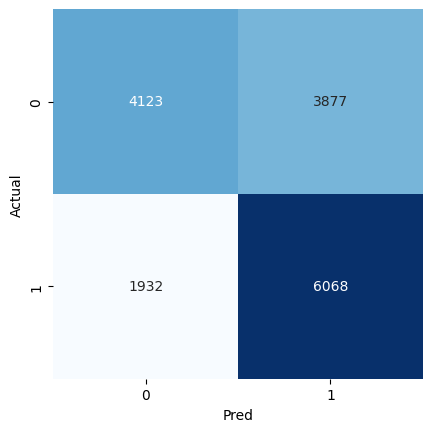

In [70]:
mat = confusion_matrix(data_to_test["home_win_flag"],
                       (data_to_test["pred"] > 0.5).astype(int))
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Pred')
plt.ylabel('Actual')

Text(113.9222222222222, 0.5, 'Actual')

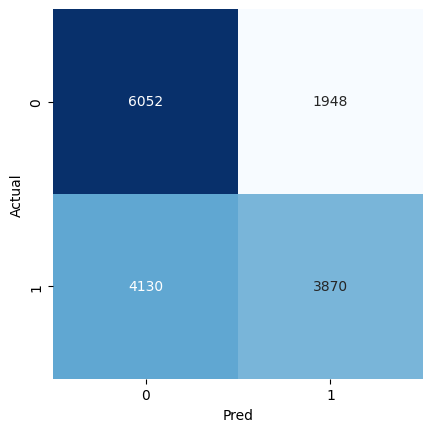

In [71]:
mat = confusion_matrix(data_to_test["home_win_flag"],
                       (data_to_test["home_win_prob"] > 0.5).astype(int))
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Pred')
plt.ylabel('Actual')

In [72]:
maxi_auc = 0
maxi_acc = 0
maxi_auc_list = []
maxi_acc_list = []


for i in range(0,99):
    
    for x in range(0,99):

        data_to_test["pred_w_odds"] =  np.where((data_to_test["home_win_prob"] > i/100) &
                                                (data_to_test["pred"] >= x/100),
                                                (data_to_test["home_win_prob"] + data_to_test["pred"])/2,
                                                np.where((data_to_test["home_win_prob"] > i/100) &
                                                         (data_to_test["pred"] < x/100),
                                                          data_to_test["home_win_prob"],
                                                          data_to_test["pred"]
                                                ))
    
        auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred_w_odds'] )
        accu = accuracy_score(data_to_test['home_win_flag'], data_to_test['pred_w_odds'] > 0.5 )
        
        if auc > maxi_auc:
            maxi_auc = auc
            maxi_auc_list = []
            maxi_auc_list.append(i)
            maxi_auc_list.append(x)
            maxi_auc_list.append(auc)
            
        if accu > maxi_acc:
            maxi_acc = accu
            maxi_acc_list = []
            maxi_acc_list.append(i)
            maxi_acc_list.append(x)
            maxi_acc_list.append(accu)

In [73]:
print("best auc cutoffs:",maxi_auc_list)
print("best accuracy cutoffs:",maxi_acc_list)

best auc cutoffs: [98, 0, 0.7020331093750001]
best accuracy cutoffs: [0, 67, 0.6448125]


# Auc focused accuracy finetuned combined best

In [60]:
i = 0
x = 67

data_to_test["pred_w_odds"] =  np.where((data_to_test["home_win_prob"] > i/100) &
                                        (data_to_test["pred"] >= x/100),
                                        (data_to_test["home_win_prob"] + data_to_test["pred"])/2,
                                        np.where((data_to_test["home_win_prob"] > i/100) &
                                                 (data_to_test["pred"] < x/100),
                                                  data_to_test["home_win_prob"],
                                                  data_to_test["pred"]))

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, _= roc_curve(data_to_test['home_win_flag'],  data_to_test['home_win_prob'])

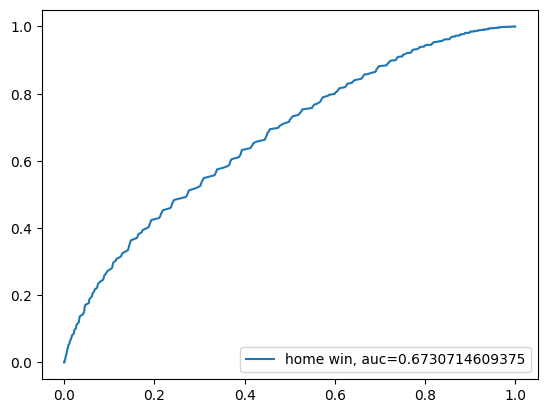

In [62]:
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['home_win_prob'] )
plt.plot(fpr,tpr,label="home win, auc="+str(auc))
plt.legend(loc=4)
plt.show()

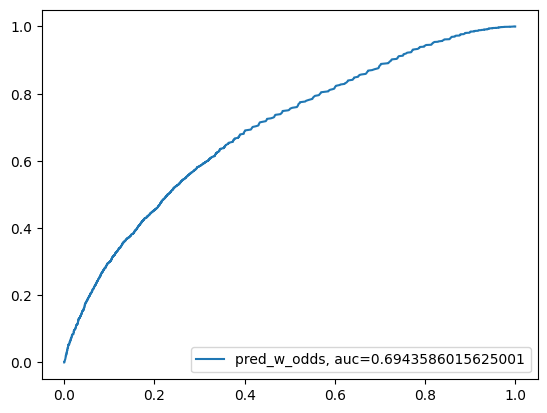

In [63]:
fpr, tpr, _= roc_curve(data_to_test['home_win_flag'],  data_to_test['pred_w_odds'])
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred_w_odds'] )
plt.plot(fpr,tpr,label="pred_w_odds, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(113.9222222222222, 0.5, 'Actual')

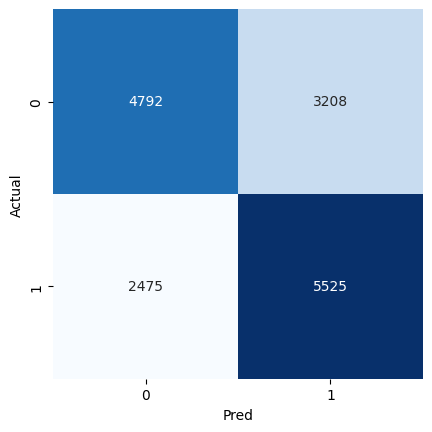

In [64]:
mat = confusion_matrix(data_to_test["home_win_flag"],
                       (data_to_test["pred_w_odds"] > 0.5).astype(int))
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Pred')
plt.ylabel('Actual')

# Save model

## 3 steps:
### - step 1 save home_win_prob snippet
### - step 2 save GaussianNB() model
### - step 3 save cutoff variables and apply the cutoffs